# Covid-19 analysis updated
This Python3 notebook is based on the original [Pharo Smalltalk version](https://github.com/olekscode/CovidAnalysis) by Oleksandr Zaitsev and is an update of the [August 2020 version](CovidAnalysis.ipynb). <br> The dataset for this Covid-19 analysis is publicly available and from 14 December 2020 published weekly on Thursdays. Where appropriate some code extensions have been added to view the supplied data from a different angle.

#### Disclaimer 
August 2020. To prevent inappropriate conclusions drawn on this highly actual subject:
* As a Data Science excercise this Covid-19 analysis is purely intended for educational purposes.
* The outcome of the code cells in this notebook should be regarded as the *technical* result of the code and not be interpreted otherwise.
* I have no opinion on the dataset provided nor am I responsible for possible misinterpretation of the outcome

#### Change history
**[August 2020](CovidAnalysis.ipynb)** initial version

**January 2021**: From 14 December 2020 the *European Centre for Disease Prevention and Control* for several reasons discontinued providing Covid-19 data on a daily basis. Instead weekly updates are published every Thursday. New columns in dataset are `cases_weekly` and `deaths_weekly`.

**February 2021**. Entirely rewritten due to new ECDC data dictionary: `indicator` attribute for either `cases` or `deaths` and new attribute `weekly_count`. As a result weekly counted cases and deaths are not in one record anymore.

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns #sets up styles and gives us more plotting options
import urllib.request
import pickle
import requests
import datetime

### Download latest COVID-19 data
Download the latest COVID-19 data from the [European Centre for Disease Prevention](https://www.ecdc.europa.eu/en/publications-data/data-national-14-day-notification-rate-covid-19).

In [2]:
def dataCsvURL():
    return 'https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/csv'

In [3]:
def dataDirectory():
    return 'data/'

In [4]:
def dataCsvFile():
    return dataDirectory() + 'covidDataWeekly.csv'

In [5]:
#Let's give it a try and save to CSV file
covidFile = requests.get(dataCsvURL())
open(dataCsvFile(), 'wb').write(covidFile.content)

2560377

### Read and clean data
Now read the data from the CSV file into a dataframe using pandas. Clean up to show the relevant columns.

In [6]:
def columnsToDisplay():
    return['year_week', 'indicator', 'weekly_count', 'country', 'population' ]

In [7]:
# Convert population to integer. Caution: astype(int) gives error "Cannot convert non-finite values (NA or inf) to integer"
def preProcessing(df):
    df['population'] = df['population'].astype('Int64')

In [8]:
df = pd.read_csv(dataCsvFile(), usecols=columnsToDisplay())
preProcessing(df)
df.sort_values(by=['year_week', 'country'], ascending=False).head(20)

,country,population,indicator,weekly_count,year_week
20689,the Holy See/ Vatican City State,809,cases,0,2021-07
20739,the Holy See/ Vatican City State,809,deaths,0,2021-07
22802,Zimbabwe,14862927,cases,690,2021-07
22851,Zimbabwe,14862927,deaths,41,2021-07
22704,Zambia,18383956,cases,6145,2021-07
22753,Zambia,18383956,deaths,89,2021-07
22609,Yemen,29825968,cases,20,2021-07
22655,Yemen,29825968,deaths,1,2021-07
22519,Western Sahara,597330,cases,0,2021-07
22563,Western Sahara,597330,deaths,0,2021-07


#### One country
The core of western civilization and a popular holiday destination:

In [9]:
df.query("country == 'Greece'").sort_values(by=['year_week'], ascending=False).head(10)

,country,population,indicator,weekly_count,year_week
8721,Greece,10718565,deaths,171,2021-07
8661,Greece,10718565,cases,7674,2021-07
8660,Greece,10718565,cases,8182,2021-06
8720,Greece,10718565,deaths,154,2021-06
8659,Greece,10718565,cases,6989,2021-05
8719,Greece,10718565,deaths,176,2021-05
8658,Greece,10718565,cases,4977,2021-04
8718,Greece,10718565,deaths,150,2021-04
8717,Greece,10718565,deaths,177,2021-03
8657,Greece,10718565,cases,3373,2021-03


### Top 10 countries of reported cases  (in numbers)
This is an aggregate action on the dataframe. As a beginner in Data science and Pandas I find it cumbersome to get these top 10 countries of reported cases. IMO **Pharo's Smalltalk** solution below is much cleaner and easier to understand.

```
(df group: 'cases' by: 'country' aggregateUsing: #sum)
	sortDescending
	head: 10.
```

To find the 10 countries having the least reported cases simply replace `head` by `tail`. <br><br> February 2021: totals for continents and EU are excluded.

In [10]:
gPerCountry = df.groupby('country')
casesPerCountry = gPerCountry.apply(lambda x: x[x['indicator'] == 'cases']['weekly_count'].sum())
print(type(casesPerCountry))
casesPerCountry=casesPerCountry.drop(labels=['Oceania (total)', 'America (total)', 'Europe (total)', 'EU/EEA (total)','Africa (total)', 'Asia (total)'])
sortedCasesPerCountry = casesPerCountry.sort_values(ascending=False)
sortedCasesPerCountry.head(20)

<class 'pandas.core.series.Series'>


country
United States     28767050
India             11005850
Brazil            10195160
Russia             4177330
United Kingdom     4115509
France             3605181
Spain              3153971
Italy              2809246
Turkey             2638422
Germany            2390928
Colombia           2229663
Argentina          2069751
Mexico             2043632
Poland             1638767
Iran               1574012
South Africa       1503796
Ukraine            1307662
Peru               1286757
Indonesia          1271353
Czechia            1157180
dtype: int64

### Top 10 countries of reported cases  (relative population)
Another approach is to collect the number of cases in a country relative to the population.

In [11]:
# Find 10 countries with relatively highest cases
gPerCountry = df.groupby('country')

casesPerCountry = gPerCountry.apply(lambda x: x[x['indicator'] == 'cases']['weekly_count'].sum())
populationPerCountry = df.groupby('country').mean()[['population']]
populationPerCountry['cases weekly (%)']=casesPerCountry / populationPerCountry['population'] * 100
populationPerCountry.sort_values(by=['cases weekly (%)'], ascending=False).head(10)

,population,cases weekly (%)
country,,
Andorra,76177,14.044922
Gibraltar,33691,12.549346
Montenegro,621873,11.577123
Czechia,10693939,10.820896
San Marino,34453,10.077497
Slovenia,2095861,8.815804
Israel,8655541,8.692674
United States,331002647,8.690882
Luxembourg,626108,8.646751


### Top 10 countries of reported deaths (in numbers)
To find the 10 countries having the least reported Covid-19 deaths (cumulative) simply replace `head` by `tail`. <br><br> February 2021: totals for continents and EU are excluded.

In [12]:
gPerCountry = df.groupby('country')
deathsPerCountry = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['weekly_count'].sum())
deathsPerCountry=deathsPerCountry.drop(labels=['Oceania (total)', 'America (total)', 'Europe (total)', 'EU/EEA (total)','Africa (total)', 'Asia (total)'])
sortedDeathsPerCountry = deathsPerCountry.sort_values(ascending=False)
sortedDeathsPerCountry.head(20)


country
United States     511216
Brazil            247143
Mexico            180536
India             156385
United Kingdom    120580
Italy              95718
France             84306
Russia             83630
Germany            67903
Spain              67636
Iran               59483
Colombia           58974
Argentina          51359
South Africa       49053
Peru               45263
Poland             42171
Indonesia          34316
Turkey             28060
Ukraine            25156
Belgium            21936
dtype: int64

### Top 10 countries of reported deaths  (relative population)
Another approach is to collect the number of deaths in a country relative to the population.

In [13]:
# Find 10 countries with relatively highest deaths
gPerCountry = df.groupby('country')
deathsPerCountry = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['weekly_count'].sum())
populationPerCountry = df.groupby('country').mean()[['population']]
populationPerCountry['deaths weekly (%)']=deathsPerCountry / populationPerCountry['population'] * 100
populationPerCountry.sort_values(by=['deaths weekly (%)'], ascending=False).head(10)

,population,deaths weekly (%)
country,,
Gibraltar,33691,0.267134
San Marino,34453,0.208980
Slovenia,2095861,0.193572
Belgium,11522440,0.190376
Czechia,10693939,0.180757
United Kingdom,68059863,0.177168
Italy,59641488,0.160489
Portugal,10295909,0.155032
United States,331002647,0.154445


### Covid-19 spread in The Netherlands

In [14]:
df_country = df[df.country=='Netherlands']
relevant_columns = ['year_week', 'indicator', 'weekly_count']
covid_df_country = df_country[relevant_columns]
covid_df_country.sort_values(by=['year_week'], ascending=False).head(10)

,year_week,indicator,weekly_count
14861,2021-07,deaths,405
14801,2021-07,cases,28657
14800,2021-06,cases,24069
14860,2021-06,deaths,414
14799,2021-05,cases,26270
14859,2021-05,deaths,403
14798,2021-04,cases,28671
14858,2021-04,deaths,445
14857,2021-03,deaths,522
14797,2021-03,cases,35590


### Max weekly cases in The Netherlands
Find the week when most cases were reported

In [15]:
maxWeeklyCases = covid_df_country['weekly_count'].max()
covid_df_country[(covid_df_country.weekly_count==maxWeeklyCases)]


,year_week,indicator,weekly_count
14793,2020-52,cases,80594


### Max weekly deaths in The Netherlands
Find the week when most deaths were reported

In [16]:
gPerCountry = covid_df_country.groupby('indicator')
deaths = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['weekly_count'].max())
covid_df_country[(covid_df_country.weekly_count==deaths.deaths)]


,year_week,indicator,weekly_count
14815,2020-14,deaths,995


### Cumulative sum of cases and deaths
To find the total number of reported cases and deaths up to a date in the Netherlands

In [17]:
def compressed_country_df(df):
    gPerCountry = df.groupby('indicator')
    cases = gPerCountry.apply(lambda x: x[x['indicator'] == 'cases']['weekly_count']).values
    deaths = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['weekly_count']).values
    names = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['country']).values
    population = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['population']).values
    cumulativeCases = gPerCountry.apply(lambda x: x[x['indicator'] == 'cases']['weekly_count'].cumsum(axis = 0)).values
    cumulativeDeaths = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['weekly_count'].cumsum(axis = 0)).values
    df_new = pd.DataFrame()
    df_new['country'] = names
    df_new['population'] = population
    df_new['year_week'] = df['year_week'].unique()
    df_new['cases_weekly'] = cases
    df_new['deaths_weekly'] = deaths
    df_new['cumulative_cases'] = cumulativeCases
    df_new['cumulative_deaths'] = cumulativeDeaths
    return df_new

In [18]:
df_country = df[df.country=='Netherlands']
dfNL=compressed_country_df(df_country)
dfNL.sort_values(by=['year_week'], ascending=False).head(20)

,country,population,year_week,cases_weekly,deaths_weekly,cumulative_cases,cumulative_deaths
59,Netherlands,17407585,2021-07,28657,405,1059443,15231
58,Netherlands,17407585,2021-06,24069,414,1030786,14826
57,Netherlands,17407585,2021-05,26270,403,1006717,14412
56,Netherlands,17407585,2021-04,28671,445,980447,14009
55,Netherlands,17407585,2021-03,35590,522,951776,13564
54,Netherlands,17407585,2021-02,38967,645,916186,13042
53,Netherlands,17407585,2021-01,57026,799,877219,12397
52,Netherlands,17407585,2020-53,50699,570,820193,11598
51,Netherlands,17407585,2020-52,80594,551,769494,11028
50,Netherlands,17407585,2020-51,76154,443,688900,10477


### Reported cases and deaths in the Netherlands
How is Covid-19 moving in time? This plot merely prints the weekly figures. The whereabouts of the data should be given before any conclusion may be drawn. E.g. consider the fact that the test capacity is now considerably higher than after the outbreak of the virus and has an important impact on the number of reported contaminations. However the number of confirmed deaths might be a more reliable indicator.

Text(0, 0.5, 'Weekly Count')

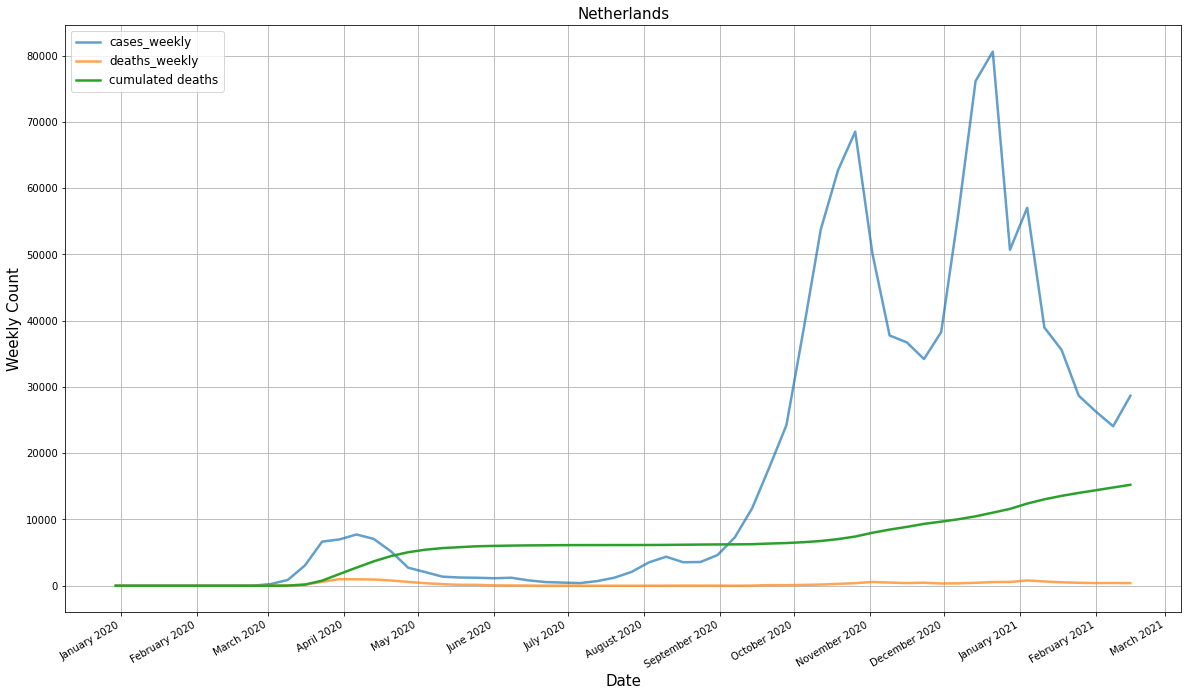

In [19]:
plt.figure(figsize=(20,12))
for i in ['cases_weekly', 'deaths_weekly']: 
    #convert strings to dates. All weeks starting on Monday. Week numbering follows ISO week date standard (ISO-8601).
    x = [datetime.datetime.strptime(d + '-1', "%G-%V-%u") for d in dfNL.year_week.values]
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%B %Y'))
    plt.gca().xaxis.set_major_locator(mpl.dates.MonthLocator())
    plt.plot(x, dfNL[i], alpha=0.7, label=i, linewidth='2.5')
    plt.gcf().autofmt_xdate()

plt.plot (x, dfNL['cumulative_deaths'], label='cumulated deaths', linewidth='2.5')
plt.legend(loc="upper left", prop={'size': 12})
plt.grid()
plt.title('Netherlands', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Weekly Count', fontsize=15)

### Plot data several countries
For some European countries the weekly reported deaths are plotted in absolute numbers, relative to the population and cumulated. Justification country choice:
* Italy => first European country hit by Covid-19
* United_Kingdom => British variant of Covid-19
* Austria and Poland => comparatively small effect in 1st wave
* Belgium => comparatively high effect in 1st wave
* Netherlands => where I live

Change the `countries` list to show other countries.

#### Absolute numbers

Text(0, 0.5, 'Count')

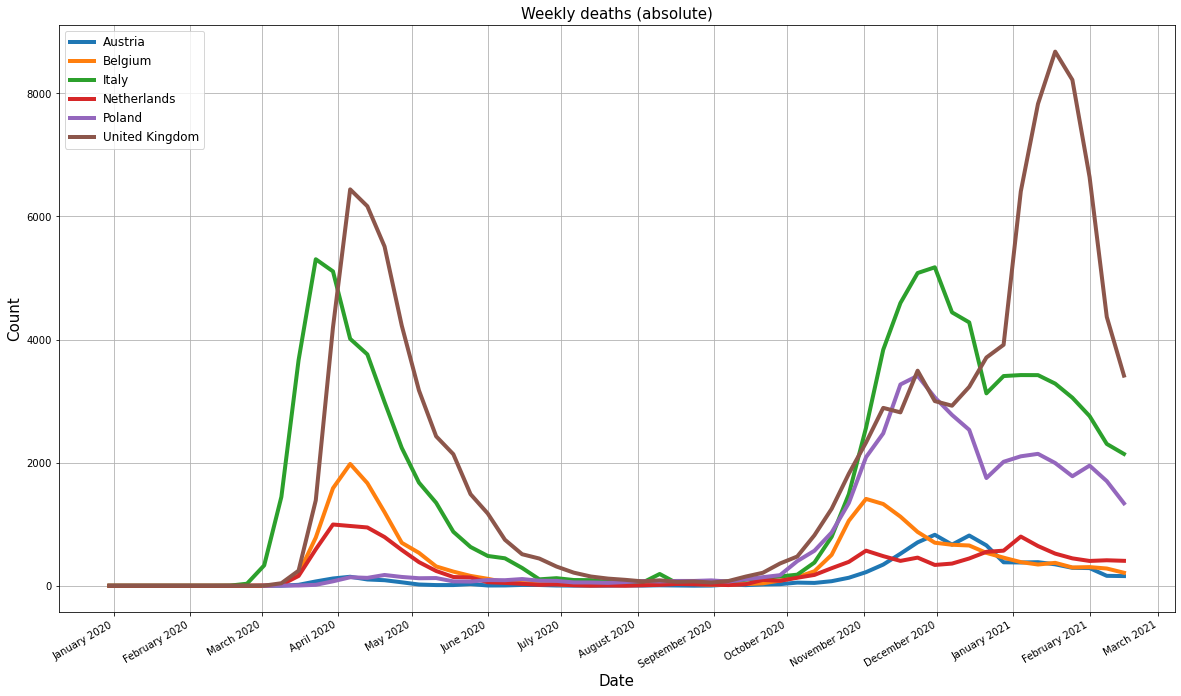

In [20]:
countries = ['Austria', 'Belgium', 'Italy', 'Netherlands', 'Poland', 'United Kingdom']
df_countries = [df[df.country==country] for country in countries]
dfs=[compressed_country_df(df) for df in df_countries]
plt.rcParams["figure.figsize"] = [20,12]
for covid_df_country in dfs:
    lbl = next(iter(set(covid_df_country.country.values))) 
    x = [datetime.datetime.strptime(d + '-1', "%G-%V-%u") for d in covid_df_country.year_week.values] #convert strings to dates
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%B %Y'))
    plt.gca().xaxis.set_major_locator(mpl.dates.MonthLocator())
    plt.plot(x, covid_df_country.deaths_weekly, alpha=1.0, label=lbl, linewidth=4.0)
    plt.gcf().autofmt_xdate()
    plt.legend(loc="upper left",  prop={'size': 12})
plt.grid()
plt.title('Weekly deaths (absolute)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)


#### Relative population

Text(0, 0.5, 'Count')

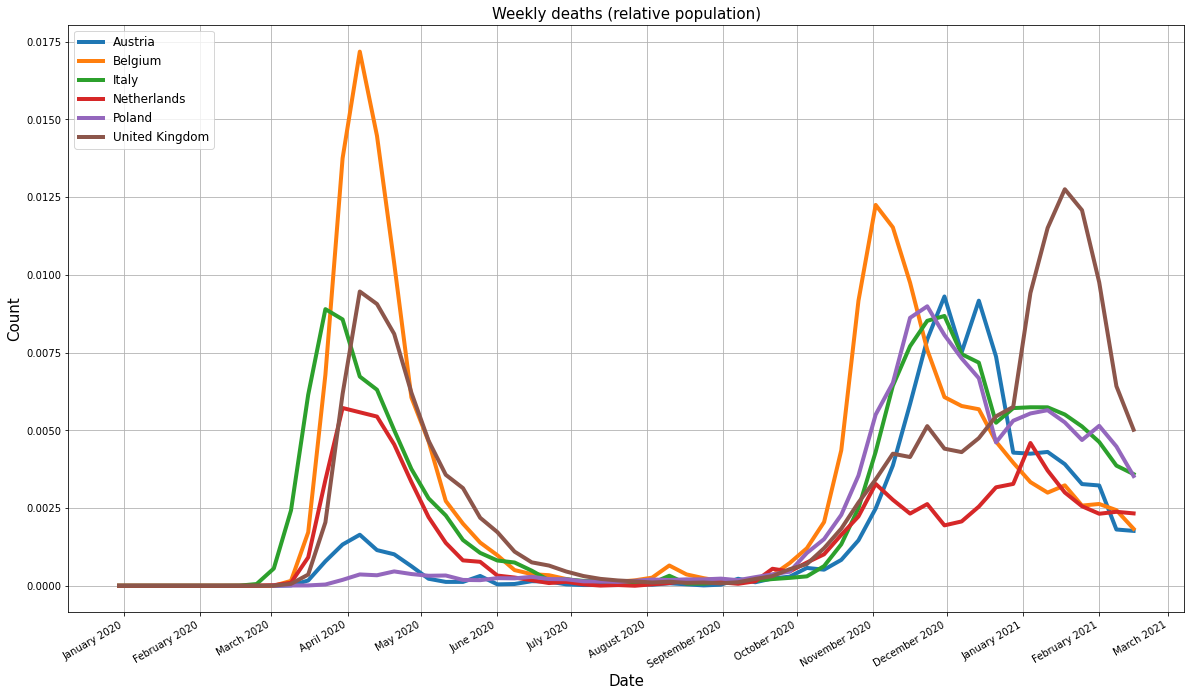

In [21]:
plt.rcParams["figure.figsize"] = [20,12]
for covid_df_country in dfs:
    lbl = next(iter(set(covid_df_country.country.values))) 
    x = [datetime.datetime.strptime(d + '-1', "%G-%V-%u") for d in covid_df_country.year_week.values] #convert strings to dates
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%B %Y'))
    plt.gca().xaxis.set_major_locator(mpl.dates.MonthLocator())
    y = covid_df_country.deaths_weekly / covid_df_country.population * 100
    plt.plot(x, y , alpha=1.0, label=lbl, linewidth=4.0)
    plt.gcf().autofmt_xdate()
    plt.legend(loc="upper left",  prop={'size': 12})
plt.grid()
plt.title('Weekly deaths (relative population)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)

#### Cumulated

Text(0, 0.5, 'Count')

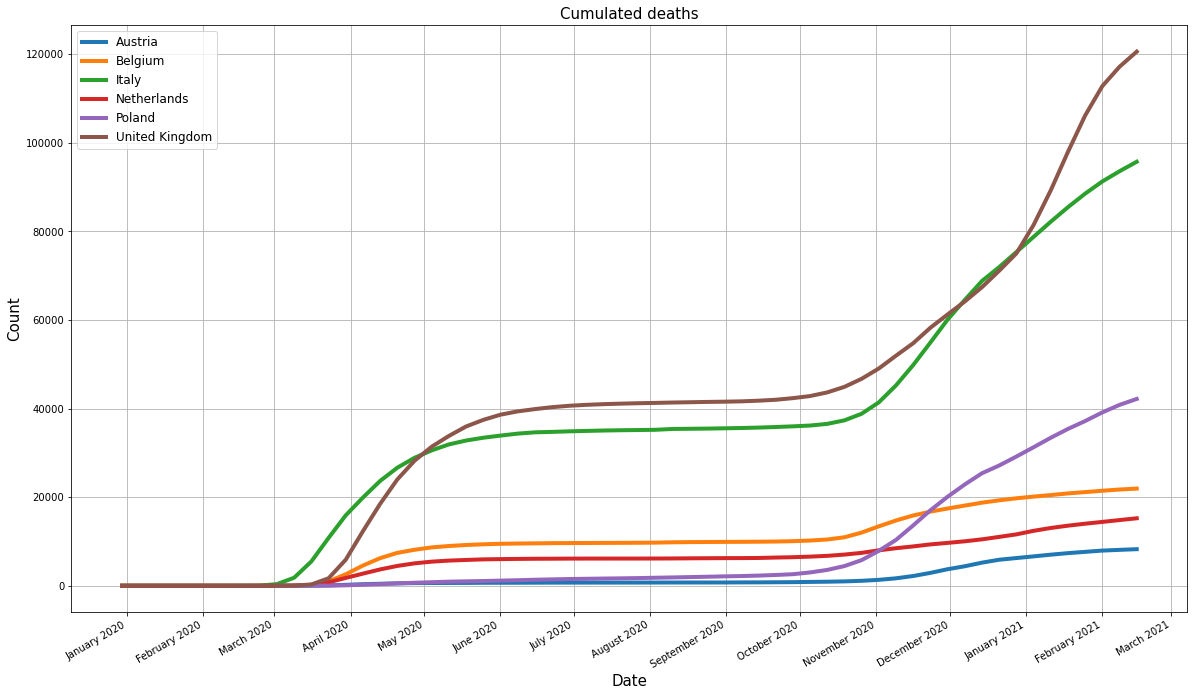

In [22]:
plt.rcParams["figure.figsize"] = [20,12]
for covid_df_country in dfs:
    lbl = next(iter(set(covid_df_country.country.values))) 
    x = [datetime.datetime.strptime(d + '-1', "%G-%V-%u") for d in covid_df_country.year_week.values] #convert strings to dates
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%B %Y'))
    plt.gca().xaxis.set_major_locator(mpl.dates.MonthLocator())
    plt.plot(x, covid_df_country['cumulative_deaths'], alpha=1.0, label=lbl, linewidth=4.0)
    plt.gcf().autofmt_xdate()
    plt.legend(loc="upper left", prop={'size': 12})
plt.grid()
plt.title('Cumulated deaths', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)

#### Visualisation in Tableau Public
February 2021: the Tableau Public dashboard reflects the situation up to 08-02-2021.<br><br>If the Tableau visualisation doesn't show up, try it in [Jupyter's nbviewer](https://nbviewer.jupyter.org/github/HodaAtWork/DS-miniatures/blob/master/Python/CovidAnalysisUpdated.ipynb).

In [25]:
%%html
<div class='tableauPlaceholder' id='viz1612728645244' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Mo&#47;MortalilityrateCovid-19ECDC&#47;Deaths-Covid-19&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='MortalilityrateCovid-19ECDC&#47;Deaths-Covid-19' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Mo&#47;MortalilityrateCovid-19ECDC&#47;Deaths-Covid-19&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1612728645244');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='1727px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>